<img src="Q/ex3.6.png">
<img src="Q/ex3.6.1.png">

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
from mpl_toolkits import mplot3d
plt.rcParams.update({'font.size': 14})

from utilities import error, convert1D_to_2D, plot_phi,residual
def prepare_phi_and_S(Nx,Ny,phi,L, H, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))
    dx = L/(Nx-1)    # Grid size
    dy = H/(Ny-1)    # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            
            source = 1
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source

    
    ## Right BC
    DphiDx_R = 1
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i*dx
        y = j*dy
        
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phiR = dx + phi[k-Nx]
            phiR = (2*DphiDx_R*dx- 4*phi[k-Nx] + phi[k-2*Nx])/ (-3)
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i*dx
        y = j*dy
        
        phiL = 0

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiB = 0
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiT = 0
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S


In [20]:
def stonesmethod(N, K, B, D, E, F, H):
    d, e, c, b, f = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)
    # Bbar,Cbar,Dbar,Ebar,Fbar,Gbar,Hbar = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    alpha = 0.8

    # Step 3
    d[0] = E[0]
    e[0] = F[0] / d[0]
    f[0] = H[0] / d[0]

    for k in range(1, K):
        if k > N:
            b[k] = B[k] / (1 + alpha * e[k - N])
        # print(k, K, c.shape)
        c[k] = D[k] / (1 + alpha * f[k - 1])

        if k > N:
            d[k] = E[k] + alpha * (b[k] * e[k - N] + c[k] * f[k - 1]) - b[k] * f[k - N] - c[k] * e[k - 1]
        else:
            d[k] = E[k] + alpha * (c[k] * f[k - 1]) - c[k] * e[k - 1]

        f[k] = (H[k] - alpha * c[k] * f[k - 1]) / d[k]

        if k > N:
            e[k] = (F[k] - alpha * b[k] * e[k - N]) / d[k]

        else:
            e[k] = F[k] / d[k]

    return b, c, d, e, f

def Stones(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    
    tol = 1e-6
    L = np.zeros((Nx ** 2, Ny ** 2))
    U = np.zeros((Nx ** 2, Ny ** 2))
    ## Right BC
    i = Nx - 1
    for j in range(1,Ny-1):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1

    ## left BC
    i = 0
    for j in range(1,Ny-1):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1
    ## Bottom BC
    j = 0
    for i in range(Nx):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1
    ## Top BC
    j = Ny - 1
    for i in range(Nx):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1

    aE = 1 / dx ** 2
    aW = 1 / dx ** 2
    aN = 1 / dy ** 2
    aS = 1 / dy ** 2
    a0 = -(2 / dx ** 2 + 2 / dy ** 2)


    # Step 
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)

    s = time.time()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            k = (j - 1) * Nx + i
            b, c, d, e, f = stonesmethod(Nx, k, B, D, E, F, H)

            # print(k)

            L[k, k] = d[k-1]
            L[k, k - 1] = c[k-1]
            L[k, k - Nx] = b[k-1]

            U[k, k] = 1
            U[k, k + 1] = e[k-1]
            U[k, k + Nx] = f[k-1]

    R2 = 0
    R = np.zeros(Nx*Ny)


    for _ in tqdm(range(100000)):
        # Step 4
        # Calculate residual
        R2 = 0
        for i in range(1, Nx - 1):

            for j in range(1, Ny - 1):
                x = i * dx
                y = j * dy
                k = (j - 1) * Nx + i
                R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

                R2 = R2 + R[k] ** 2

        # Step 5
        Y = np.matmul(np.linalg.inv(L),R)

        # Step 6
        delta = np.matmul(np.linalg.inv(U) , Y)

        phi += delta
        # print(delta)
        R2 = np.sqrt(R2)
        Rlogger.append(R2)
        if _ % 10 == 0:
            clear_output(True)
            print("Residual: ", R2)

        if R2 < tol:
            print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
            break

    return Rlogger, phi

In [21]:
def CGS(Nx, Ny,phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    tol=1e-6
    # Same coefficient name as Stone's method
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)

    # Initial residual
    R2sum_old,R0 = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)

    # Step 3: Set the initial search direction vector equal to the residual vector
    D0 = R0
    D_conjugate = R0
    R_old = R0
    for _ in tqdm(range(100000)):

        # Compute new alpha = R0.T @ R_old / (R0.T @ A @ D)
        
        # Compute A@D
        ad = np.zeros(Nx*Ny)
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                k = (j - 1) * Nx + i
                # k = K-1
                
                ad[k] = E[k]*D0[k] + F[k]*D0[k+1] + H[k]*D0[k+Nx] + D[k]*D0[k-1] + B[k]*D0[k-Nx]
        
        # Compute R0.T @ A @ D
        r_t_ad = 0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):

                k = (j - 1) * Nx + i
                r_t_ad = r_t_ad + R0[k]*ad[k]
        

        
        alpha = R0.T @ R_old / r_t_ad

        G = D_conjugate - alpha * ad


        phi = phi + alpha*(D_conjugate + G)
        
        # Compute residual

        R2sum_new, R_new = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)    

        R2_new = np.sqrt(R2sum_new)
        
        beta = R0.T @ R_new / (R0.T @ R_old)

        # Update search direction vector
        D_conjugate = R_new + beta*G
        

        # Update old residual vector
        R2_old = R2_new
        R_old = R_new

        # Update search direction vector
        D0 = D_conjugate + beta* (G + beta*D0)
        Rlogger.append(R2_new)
        if _ % 100 == 0:
            clear_output(True)
            print(f'alpha: {alpha}')
            print("Residual: ", R2_new)

        if R2_new < tol:
            print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
            break
    return Rlogger, phi

In [28]:
# numbering scheme used is k = (j-1)*N + i

Nx = 81
Ny = 81
L = 1   # length
H = 1   # length

S = np.zeros((Nx,Ny))
phi = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = H/(Ny-1)    # Grid size

tol = 1e-3
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)




Rlogger = []

############# Stone's method #############
start = time.time()
S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H,convert_to_K=True)
Rlogger_Stones, phiS = Stones(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])
############# CG #############
start = time.time()
S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H,convert_to_K=True)

Rlogger_CG,phiC = CGS(Nx, Ny,phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])


  0%|          | 121/100000 [16:07<214:03:26,  7.72s/it]

Residual:  41.465736589830485


  0%|          | 125/100000 [16:46<223:23:50,  8.05s/it]


KeyboardInterrupt: 

In [24]:
def plot(phi,method_name, convert=False):
    figsize = ((10,6))
    if convert:
        # Analytical solution
        phi2D = np.zeros((Nx,Ny))
        # Convert phi1D to 2D
        for i in range(Nx):
            for j in range(Ny):
                k = (j-1)*Nx+ i
                phi2D[i,j]=phi[k]
        phi = phi2D

    # Plot        
    x,y = np.meshgrid(np.linspace(0,1,Nx),np.linspace(0,1,Ny), indexing='ij')
    fig, ax = plt.subplots(figsize=figsize)
    CS = ax.contour(x,y,phi) # , levels=np.arange(-30,30,5)
    ax.clabel(CS, inline=True, fontsize=10)
    CB = fig.colorbar(CS)
    ax.set_xlabel('Distance, x')
    ax.set_ylabel('Distance, y')

    ax.set_title('Numerical solution by '+method_name+' iterative solver, code by Congcong Fan')
    fig.tight_layout()

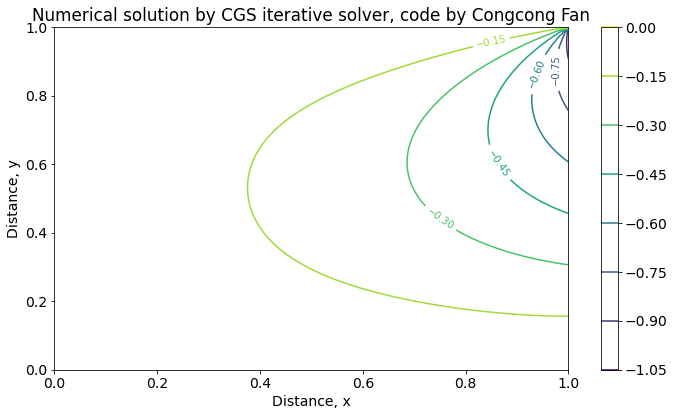

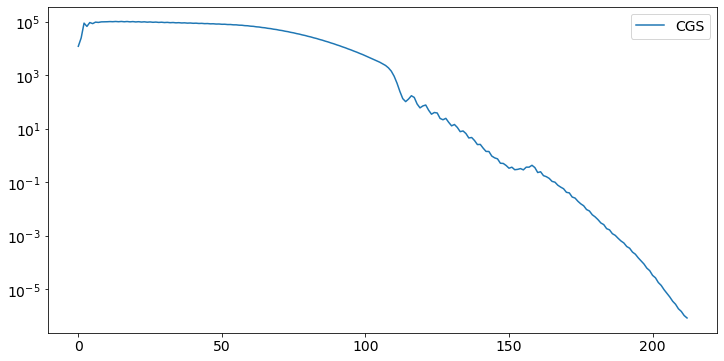

In [27]:
plot(phiC, 'CGS',convert=True)
# plot(phiS, 'Stone',convert=True)


plt.figure(figsize=(12,6))
plt.plot(Rlogger_CG,label='CGS')
# plt.plot(Rlogger_Stones,label='Stone')
plt.yscale('log')
plt.legend()


NameError: name 'dx_list' is not defined

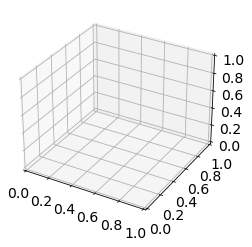

In [ ]:
fig=plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(dx_list,dy_list,phi2D)
